# CS6140 - Neural Network Approach using Bidirectional-LSTM

In the last decade, with the deep learning revolution, several LSTM architectures have been developed. Bidirectional LSTM models process information in two directions, rather than making use of only previous context state for determining the next states which are based on bidirectional RNNs. In this way, two independent LSTM models allow both backward and forward information about the sequence at every time step. This enables better access to long range state information which have been useful for word embedding and several other sequence processing problems.

In [1]:
# Importing libraries
import numpy as np 
import pandas as pd

#For data visualization
import matplotlib.pyplot as plt
import seaborn as sns

#For text preprocessing
import re
import nltk
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import TweetTokenizer
from nltk.tokenize import word_tokenize 
from nltk.corpus import stopwords

#For creating the neural network model
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow.keras.layers as L
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report

In [2]:
# Importing train and test data
train = pd.read_csv('Corona_NLP_train.csv',encoding='latin1')
test = pd.read_csv('Corona_NLP_test.csv',encoding='latin1')

train.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [3]:
print('Shape of Train datatset:',train.shape)
print('Shape of Test dataset:',test.shape)

Shape of Train datatset: (41157, 6)
Shape of Test dataset: (3798, 6)


In [4]:
#Defining variables to count the appearances of each sentiments in the dataset
dist_train = train['Sentiment'].value_counts()
dist_test = test['Sentiment'].value_counts()

Text(0, 0.5, 'Count')

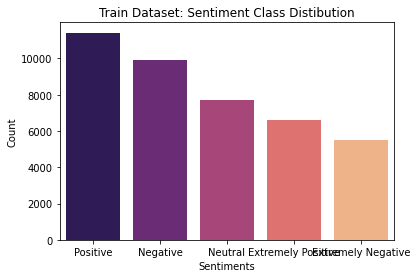

In [5]:
#Creating plot for sentiment distribution
sns.barplot(x = dist_train.index, y = dist_train.values, palette = 'magma')

#Setting the size of plot
sns.set(rc = {'figure.figsize':(10,7)})

#Setting the title for plot
plt.title('Train Dataset: Sentiment Class Distibution')

#Labeling the X axis of the plot
plt.xlabel('Sentiments')

#Labeling the Y axis of the plot
plt.ylabel('Count')

In [6]:
X = train['OriginalTweet'].copy()
y = train['Sentiment'].copy()

## Data Pre-processing

Textual data in our corpus was cleaned by removing punctuations, url, html links, emojis and special characters.

In [7]:
# Cleaning textual data
import nltk
nltk.download('stopwords')

def data_cleaner(tweet):
    
    # removing urls
    tweet = re.sub(r'http\S+', ' ', tweet)
    
    # removing html tags
    tweet = re.sub(r'<.*?>',' ', tweet)
    
    # removing digits
    tweet = re.sub(r'\d+',' ', tweet)
    
    # removing hashtags
    tweet = re.sub(r'#\w+',' ', tweet)
    
    # removing mentions
    tweet = re.sub(r'@\w+',' ', tweet)
    
    #removing stop words
    tweet = tweet.split()
    tweet = " ".join([word for word in tweet if not word in stop_words])
    
    return tweet

#Defining a variable for stopwords
stop_words = stopwords.words('english')

#Applying the above defined function to the dataset
X_cleaned = X.apply(data_cleaner)
X_cleaned.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


0                                                     
1    advice Talk neighbours family exchange phone n...
2    Coronavirus Australia: Woolworths give elderly...
3    My food stock one empty... PLEASE, panic, THER...
4    Me, ready go supermarket outbreak. Not I'm par...
Name: OriginalTweet, dtype: object

In [8]:
X_cleaned.shape

(41157,)

Tokenization of Tweets using Tokernizer() and text-to-sequences method.

In [9]:
# Tokenizing Texts
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_cleaned)

X = tokenizer.texts_to_sequences(X_cleaned)

# Initializing vocabulary size
vocab_size = len(tokenizer.word_index)+1

print("Vocabulary size: {}".format(vocab_size))
print("\nFor Example:\n")
print("Sentence:\n{}".format(X_cleaned[1]))
print("\nAfter tokenizing :\n{}".format(X[1]))

# Converting tokenized texts into same padding size
X = pad_sequences(X, padding='post')
print("\nAfter padding :\n{}".format(X[1]))

X_new = pd.DataFrame(X)
X_new.head()

Vocabulary size: 36117

For Example:

Sentence:
advice Talk neighbours family exchange phone numbers create contact list phone numbers neighbours schools employer chemist GP set online shopping accounts poss adequate supplies regular meds order

After tokenizing :
[440, 820, 2520, 201, 2636, 802, 1181, 1029, 363, 320, 802, 1181, 2520, 1163, 3517, 3254, 4534, 420, 13, 12, 2257, 18314, 3046, 120, 989, 2850, 166]

After padding :
[  440   820  2520   201  2636   802  1181  1029   363   320   802  1181
  2520  1163  3517  3254  4534   420    13    12  2257 18314  3046   120
   989  2850   166     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0]


,0,1,2,3,4,5,6,7,8,9,...,44,45,46,47,48,49,50,51,52,53
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,440,820,2520,201,2636,802,1181,1029,363,320,...,0,0,0,0,0,0,0,0,0,0
2,26,674,4360,247,259,1412,1762,12,194,91,...,0,0,0,0,0,0,0,0,0,0
3,100,5,31,33,152,37,18,140,367,303,...,0,0,0,0,0,0,0,0,0,0
4,235,685,23,6,66,124,154,3938,5,31,...,0,0,0,0,0,0,0,0,0,0


In [10]:
# Converting sentiment into three features, Positive = 2 , Neutral = 1 , Negative =  0 using label encoding
encoding = {'Extremely Negative': 0,'Negative': 0,'Neutral': 1,'Positive':2,'Extremely Positive': 2}

labels = ['Negative', 'Neutral', 'Positive']
           
y.replace(encoding, inplace=True)

## Modeling Methodology

We present a Neural Network model using Bidirectional-LSTM that compares multi-label classification.

In [11]:
tf.keras.backend.clear_session()

# Initialize hyper parameters
EPOCHS = 2
BATCH_SIZE = 32
embedding_dim = 16
units = 256

#Create a Sequential Model
model = tf.keras.Sequential([
    L.Embedding(vocab_size, embedding_dim, input_length=X.shape[1]),
    L.Bidirectional(L.LSTM(units,return_sequences=True)),
    L.GlobalMaxPool1D(),
    L.Dropout(0.4),
    L.Dense(64, activation="relu"),
    L.Dropout(0.4),
    L.Dense(3)
])

#Compile the model
model.compile(loss=SparseCategoricalCrossentropy(from_logits=True),
              optimizer='adam',metrics=['accuracy']
             )

#Show the final model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 54, 16)            577872    
                                                                 
 bidirectional (Bidirectiona  (None, 54, 512)          559104    
 l)                                                              
                                                                 
 global_max_pooling1d (Globa  (None, 512)              0         
 lMaxPooling1D)                                                  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 64)                32832     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0

LSTM Model Summary

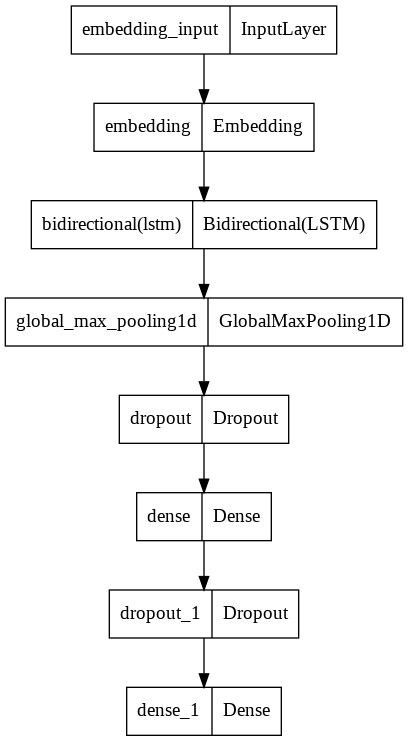

In [12]:
# Plotting the model summary for LSTM
tf.keras.utils.plot_model(model)

In [13]:
# Training the model for 2 epochs
history = model.fit(X, y, epochs=EPOCHS, validation_split=0.12, batch_size=BATCH_SIZE)

Epoch 1/2
1132/1132 [==============================] - 394s 344ms/step - loss: 0.6646 - accuracy: 0.7129 - val_loss: 0.4157 - val_accuracy: 0.8558
Epoch 2/2
1132/1132 [==============================] - 393s 347ms/step - loss: 0.3380 - accuracy: 0.8927 - val_loss: 0.3597 - val_accuracy: 0.8785


In [14]:
X_test = test['OriginalTweet'].copy()
y_test = test['Sentiment'].copy()

#Apply the tweets preprocessing functions to test dataset
X_test = X_test.apply(data_cleaner)

X_test = tokenizer.texts_to_sequences(X_test)

X_test = pad_sequences(X_test, padding='post', maxlen=54)

y_test.replace(encoding, inplace=True)

In [15]:
# Predicting the model on test data
pred = model.predict(X_test)

In [21]:
# Evaluating the model performance
loss, acc = model.evaluate(X_test,y_test,verbose=0)
print('Test loss: {}'.format(loss))
print('Test Accuracy: {}'.format(acc))

Test loss: 0.4159521460533142
Test Accuracy: 0.8575565814971924
